In [1]:
import cv2 as cv
import numpy as np
import sys
if sys.version_info[0] < 3:
    raise "Must be using Python 3";

In [2]:
def showImage(name, frame):
    cv.imshow(name, frame);
    cv.waitKey(0);
    cv.destroyAllWindows();

In [3]:
def getVideo():
    cap = cv.VideoCapture(0);
    while(True):
        _,frame = cap.read();
        cv.imshow("Frame",frame);
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release();
    cv.destroyAllWindows();
    return frame;

In [4]:
frame = getVideo()
frame = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
height = frame.shape[0]; width = frame.shape[1];
print(height, width);
showImage("Last Frame",frame)

480 640


In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from random import randint
import random
random.seed(10)

In [6]:
def getSnap(frame, x_pos,y_pos,side=5):
    img = frame[x_pos:x_pos+side,y_pos:y_pos+side]
    plt.imshow(img,cmap='Greys_r')
    return img

In [7]:
def classify(frame,iterations,size):
    x = []; y = []
    for i in range(iterations):
        row = randint(1,480 - size)
        col = randint(1,640 - size)
        print(row, col)
        img = getSnap(frame,row,col,size)
        x.append(img)
        plt.show()
        isEye = False
        inp = input("Enter 'y' if eye: ")
        if inp == 'y':
            isEye = True
        y.append(isEye)
    x_np = np.asarray(x, dtype=np.float32)
    y_np = np.asarray(y)
    return x_np,y_np
        

In [20]:
def showPositives(x,y):
    for i in range(len(y)):
        if(y[i]):
            plt.imshow(x[i],cmap='Greys_r')
            plt.show()
            
def showNegatives(x,y):
    for i in range(len(y)):
        if(y[i] == False):
            plt.imshow(x[i],cmap='Greys_r')
            plt.show()

In [40]:
tf.logging.set_verbosity(tf.logging.INFO)

def cnn_model_fn(features, labels, mode):
    input_layer = tf.reshape(features["x"],[-1,50,50,1])
    
    conv1 = tf.layers.conv2d(
                        inputs=input_layer,
                        filters = 32,
                        kernel_size=[5,5],
                        padding="same",
                        activation=tf.nn.relu)
    
   
    
    pool1 = tf.layers.max_pooling2d(inputs=conv1,pool_size=[2,2],strides=2)
    
    conv2 = tf.layers.conv2d(
                        inputs=pool1,
                        filters=64,
                        kernel_size=[5, 5],
                        padding="same",
                        activation=tf.nn.relu)
    
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    pool2_flat = tf.reshape(pool2, [-1, 8 * 8 * 64])
    
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    
    print(dropout.get_shape())
    
    logits = tf.layers.dense(inputs=dropout, units=1)
    
    print(logits.get_shape())
    
    predictions = {
      "classes": tf.argmax(input=logits, axis=1),
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=1)
    
    
    print("logits size: ", logits.get_shape(), type(logits))
    print("onehot size: ", onehot_labels.get_shape(), type(onehot_labels))
    
    
    
    
    loss = tf.losses.softmax_cross_entropy(
      onehot_labels=onehot_labels, logits=logits)
    
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
                                    loss=loss,
                                    global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
                                        labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
                                    mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [22]:
def train_eye_classifier(x_np,y_np):
    eye_classifier = tf.estimator.Estimator(
        model_fn=cnn_model_fn, model_dir="/tmp/eye_convnet_model")

    tensors_to_log = {"probabilities": "softmax_tensor"}

    logging_hook = tf.train.LoggingTensorHook(
          tensors=tensors_to_log, every_n_iter=50)

    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": x_np},
        y=y_np,
        batch_size=100,
        num_epochs=None,
        shuffle=True)

    eye_classifier.train(
        input_fn=train_input_fn,
        steps=1000,
        hooks=[logging_hook])

331 65


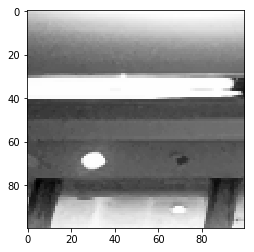

Enter 'y' if eye: 
181 349


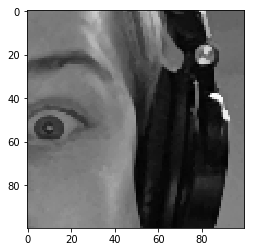

Enter 'y' if eye: y
23 305


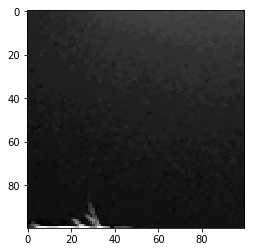

Enter 'y' if eye: 
284 309


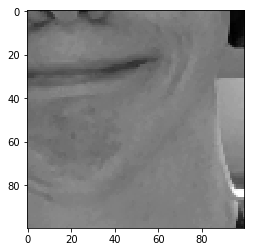

Enter 'y' if eye: 
138 23


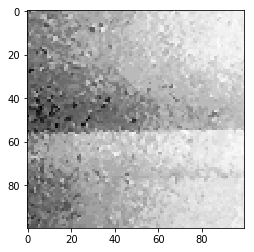

Enter 'y' if eye: 
135 349


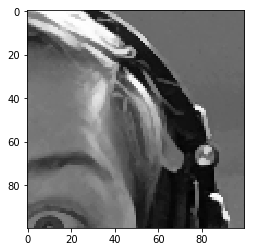

Enter 'y' if eye: 
231 305


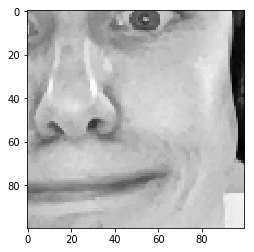

Enter 'y' if eye: y
81 55


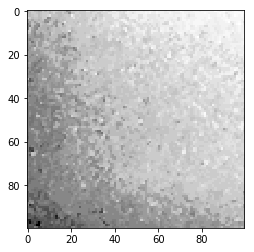

Enter 'y' if eye: 
109 258


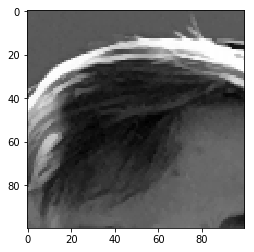

Enter 'y' if eye: 
247 202


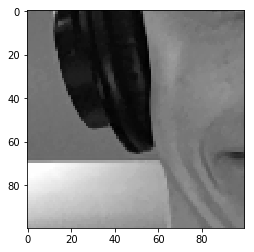

Enter 'y' if eye: 


In [41]:
x_np, y_np = classify(frame, 10, 100)

In [42]:
train_eye_classifier(x_np, y_np)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/eye_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001AAD70D6CC0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
(900, 1024)
(900, 1)
logits size:  (900, 1) <class 'tensorflow.python.framework.ops.Tensor'>
onehot size:  (100, 1) <class 'tensorflow.python.framework.ops.Tensor'>


TypeError: slice() missing 3 required positional arguments: 'input_', 'begin', and 'size'